## Libraries

In [2]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 6.3 MB/s 
     |████████████████████████████████| 287 kB 32.2 MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import contractions
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
import multiprocessing
from gensim.models import Word2Vec
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

from pathlib import Path
import shutil
import requests

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
try: 
    from google.colab import drive
    drive.mount('/content/drive')
    project_dir = Path('/content/drive/MyDrive/NLP_project_2/')    
except ModuleNotFoundError: # running on local machine
    project_dir = Path.cwd()

print(f'using project directory: "{project_dir}"')

## Import Data

In [5]:
def download_file(url, dest_dir, force=False):
    url = "https://www.statmt.org/europarl/v7/it-en.tgz"
    dest_file = Path(dest_dir, url.split('/')[-1])
    if dest_file.is_file() and not force:
        print(f'File {dest_file} already exists, use force=True to download anyways')
        return dest_file
    
    with requests.get(url, stream=True) as resp: 
        bytes_dl = 0
        total_bytes = int(resp.headers.get('content-length', 0))
        with open(dest_file, 'wb') as dest:
            for chunk in resp.iter_content(8196):
                bytes_dl += len(chunk)
                print(f"\rdownloading... {bytes_dl/total_bytes:.2%}", end='', flush=True)
                dest.write(chunk)
    return dest_file

In [37]:
source_url= "https://www.statmt.org/europarl/v7/it-en.tgz"

# download tar file
tar_file = download_file(source_url, project_dir/'data')
# unzip tar
shutil.unpack_archive(tar_file, project_dir/'data')

en_corpus_file = project_dir/'data'/'europarl-v7.it-en.en'
it_corpus_file = project_dir/'data'/'europarl-v7.it-en.it'

checkpoint_dir = project_dir / 'checkpoints'
checkpoint_dir.mkdir(exist_ok=True)

assert en_corpus_file.is_file()
assert it_corpus_file.is_file()

File /content/drive/MyDrive/NLP_project_2/data/it-en.tgz already exists, use force=True to download anyways


In [38]:
def read_file(file_name, col_name):
  with open(file_name, 'r', encoding='utf-8') as f:
    return pd.DataFrame(f.readlines(), columns=[col_name])

In [9]:
en_data = read_file(en_corpus_file, 'en')
it_data = read_file(it_corpus_file, 'it')
data = pd.concat([en_data, it_data], axis="columns").sample(frac=0.1)
display(data.head())

,en,it
1722341,Question No 4 by Felipe Camisón Asensio (H-039...,"Annuncio l'interrogazione n. 4, dell'onorevole..."
510465,The Commission’s proposal seeks to strike a ba...,La proposta della Commissione tenta di stabili...
428042,There are many ways in which this can be recti...,Vi sono molti modi per correggere questa situa...
956103,At the same time we have rehabilitated almost ...,"Allo stesso tempo, abbiamo reintegrato quasi 2..."
336865,There is a saying: 'do not bite off more than ...,Esiste un proverbio spagnolo che dice: 'chi tr...


## Task 1: Data exploration (10%)
For this task you should extract some insights (i.e., some statistics and graphs) from the provided data.

It could be the length differences between two languages and also the number of sentences in the
whole corpus. Don’t limit yourself into these examples and try to find more insights in the data. Please
highlight some of the most important findings in your report.

Moreover, since the dataset is too large, randomly select 10% of data (data sampling) to train your
models on in the next steps.

Hint: if you faced codec errors in reading files, the “codecs” library could be used.

Insights:
- length in chars or in words (one or the other?)
- length difference
- number of sentences
- vocabulary size
- words common in both languages?

## Length in chars

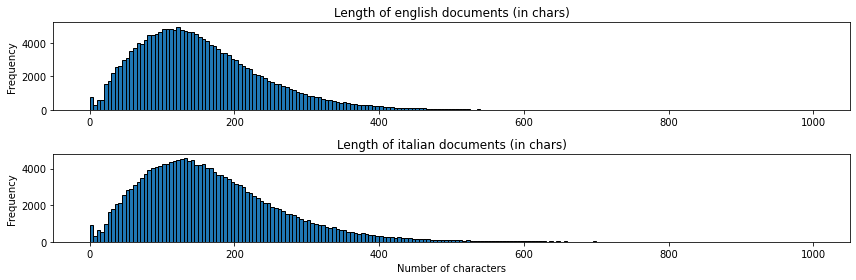

In [10]:
fig, axes = plt.subplots(2, figsize=(12,4))
data['en'].str.len().plot(kind='hist', bins=200, range=[0, 1000], ax=axes[0], title='Length of english documents (in chars)', edgecolor='black')
data['it'].str.len().plot(kind='hist', bins=200, range=[0, 1000], ax=axes[1], title='Length of italian documents (in chars)', edgecolor='black')
plt.xlabel("Number of characters")
fig.tight_layout()
plt.show()

## Length in words

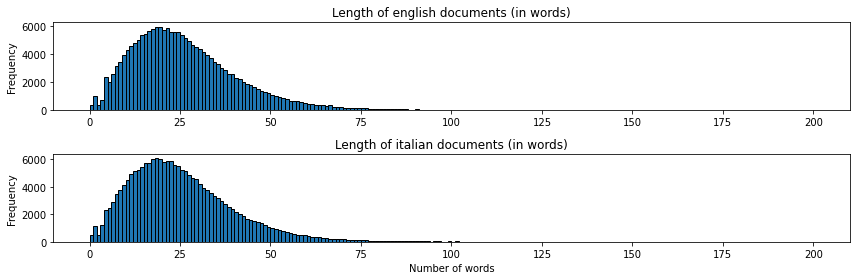

In [11]:
fig, axes = plt.subplots(2, figsize=(12,4))
data['en'].str.split().map(lambda x:len(x)).plot(kind='hist', bins=200, range=[0, 200], ax=axes[0], title='Length of english documents (in words)', edgecolor='black')
data['it'].str.split().map(lambda x:len(x)).plot(kind='hist', bins=200, range=[0, 200], ax=axes[1], title='Length of italian documents (in words)', edgecolor='black')
plt.xlabel("Number of words")
fig.tight_layout()
plt.show()

## Length difference

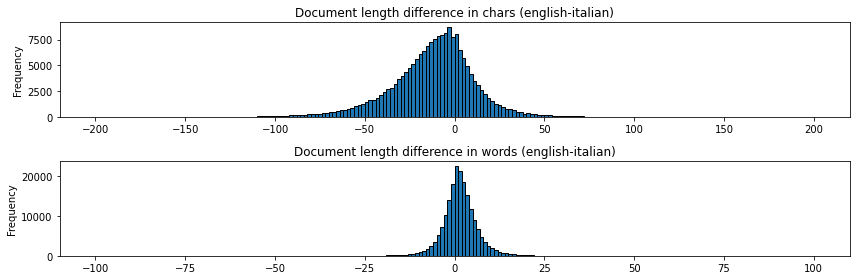

In [12]:
fig, axes = plt.subplots(2, figsize=(12,4))
(data['en'].str.len()-data['it'].str.len()).plot(kind='hist', bins=200, range=[-200, 200], ax=axes[0], title='Document length difference in chars (english-italian)', edgecolor='black')
(data['en'].str.split().map(lambda x:len(x))-data['it'].str.split().map(lambda x:len(x))).plot(kind='hist', bins=200, range=[-100, 100], ax=axes[1], title='Document length difference in words (english-italian)', edgecolor='black')
fig.tight_layout()
plt.show()

## Number of sentences

In [13]:
# split each cell into sentences 
tokenized_data_en = data['en'].map(lambda s: sent_tokenize(s)).copy()
tokenized_data_it = data['it'].map(lambda s: sent_tokenize(s)).copy()
nb_en_sentences = tokenized_data_en.map(lambda l: len(l)).sum()
nb_it_sentences = tokenized_data_it.map(lambda l: len(l)).sum()

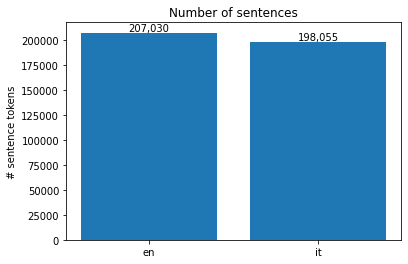

In [14]:
labels = ['en', 'it']
values = [nb_en_sentences, nb_it_sentences]

# Plot the figure.
fig, ax = plt.subplots()
plt.bar(labels, values)
ax.set_title("Number of sentences")
ax.set_ylabel("# sentence tokens")
ax.set_xticklabels(labels)

rects = ax.patches

for rect, value in zip(rects, values):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, f'{value:,}', ha="center", va="bottom"
    )

plt.show()

## Vocabulary size

In [15]:
def wordCount(data):
  word_counter = Counter()
  tokenized_data = data.map(lambda s: word_tokenize(s.lower())).copy()
  tokenized_data.apply(word_counter.update)
  return word_counter

en_vocab = set(wordCount(data['en']).keys())
it_vocab = set(wordCount(data['it']).keys())

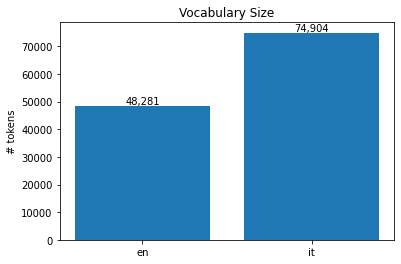

In [16]:
labels = ['en', 'it']
values = [len(en_vocab), len(it_vocab)]

# Plot the figure.
fig, ax = plt.subplots()
plt.bar(labels, values)
ax.set_title("Vocabulary Size")
ax.set_ylabel("# tokens")
ax.set_xticklabels(labels)

rects = ax.patches

for rect, value in zip(rects, values):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, f'{value:,}', ha="center", va="bottom"
    )

plt.show()

## Task 2: Pre-processing (15%)
In this task, first, apply all the necessary pre-processing steps that you think they would help to better prepare your data for the next steps. You don’t have to apply all the pre-processing tasks which are
covered in the course. Regarding the report, you should briefly mention it in your report that why you
decided to apply the chosen pre-processing steps (and why not the others).

Among all the pre-processing tasks, the following are recommended:

- lowercase the text

- strip empty lines and their correspondences

- remove lines with XML-Tags (starting with "<")

=> note: there are no lines starting with "<", but there are lines containing: >some words= , is this what is meant here?

our ideas:
- seperate punctuation/special characters from words (Hello! --> Hello !) => word_tokenize does this actually
- undo compact forms (ex: I'm --> I am)
- remove special characters < and =
- many sentences contain the legal report number ex: (A5-0052/1999) -> remove substrings of format: '\([A-Z][0-9]-[0-9]{4}\/[0-9]{4}\)'
- many sentences start with for ex: - (SV) or . (PT) -> remove substrings of format: '- \([A-Z][A-Z]\)' and '. \([A-Z][A-Z]\)'
- any pre processing specific to Italian?

In [17]:


# "^[^a-zA-Z]*$" --- any sentence not containing letters

def removeLegals(text):
  text = re.sub(pattern=r'\([A-Z][0-9]-[0-9]{4}\/[0-9]{2,4}\)', repl='', string=text)
  text = re.sub(pattern=r'(. )?\([A-Z]{2}\)', repl='', string=text)
  return text

def prep(text):
  special_chars = ['>', '=']
  text = removeLegals(text)                                     # remove substrings related to legal reports
  text = text.translate({ord(c): " " for c in special_chars})   # remove special characters
  text = text.lower()                                           # lower case
  text = contractions.fix(text)                                 # undo contractions
  tokens = word_tokenize(text)                                  # tokenize: seperates punctuation from words
  return tokens

def preprocess(data):
  prep_data = data.replace('\n', np.nan).dropna() # strip empty lines
  prep_data['en'] = prep_data['en'].map(lambda t: prep(t)).copy()
  prep_data['it'] = prep_data['it'].map(lambda t: prep(t)).copy()
  return prep_data, prep_data['en'].tolist(), prep_data['it'].tolist()

In [18]:
en_it_df, en_sent_list, it_sent_list = preprocess(data)

# append "start of sentence" and "end of sentence" tokens so that the embedding algorithms learn an embedding for these tokens
en_sent_list.append(['<SOS>'])
en_sent_list.append(['<EOS>'])
it_sent_list.append(['<SOS>'])
it_sent_list.append(['<EOS>'])

In [19]:
print(en_sent_list[0])
print(it_sent_list[0])

['question', 'no', '4', 'by', 'felipe', 'camisón', 'asensio', '(', 'h-0393/98', ')']
['annuncio', "l'interrogazione", 'n.', '4', ',', "dell'onorevole", 'felipe', 'camisón', 'asensio', '(', 'h-0393/98', ')', ':']


## Task 3: Neural Machine Translation (45%)
In this task you should do the following sub-tasks. Choose two evaluation metrics and report your
results using these two metrics.

- Split data into train, validation and test sets. Use 20% of data as the test set.

- Develop an RNN based sequence to sequence model (encoder-decoder) to translate English
input into Italian text.

  - In your report describe your reasons for choosing the architecture that you are using
for the task

  - Track the impact of different embedding models (e.g., Glove, Word2Vec and …) on
the performance of your model.

  - Interpret the results of your model in the report. Does the length of text impact on
the performance of the model? What characteristic of sentences led to better
translation by the model?

- Change your input and target languages (Translate from Italian to English) and train your mode again. Compare the results in this step with the results from the previous step where English
was the input language.

- Develop a character-based model that train to translate characters into the target language. Compare the results by this model with the achieved results from the word-based models before.

Please report all the achieved results with either models in your report document. Moreover, describe
the hyper-parameters of your neural network model in the report.

### Embeddings
- Glove
- Word2Vec
  - with CBOW
  - with skip-gram

In [20]:
VECTOR_SIZE = 32

#### Word2Vec (skip-gram)

In [36]:
cores = multiprocessing.cpu_count()

# Training english word2vec (skip-gram) model
w2v_sg_en_model = Word2Vec(min_count=1, 
                           window=2, 
                           size=VECTOR_SIZE, 
                           sg=1, 
                           workers=cores-1)
w2v_sg_en_model.build_vocab(en_sent_list)
w2v_sg_en_model.train(en_sent_list, total_examples=w2v_sg_en_model.corpus_count, epochs=10, report_delay=1)

# Training italian word2vec (skip-gram) model
w2v_sg_it_model = Word2Vec(min_count=1, 
                           window=2, 
                           size=VECTOR_SIZE, 
                           sg=1, 
                           workers=cores-1)
w2v_sg_it_model.build_vocab(it_sent_list)
w2v_sg_it_model.train(it_sent_list, total_examples=w2v_sg_it_model.corpus_count, epochs=10, report_delay=1)

w2v_sg_en_model.save(str(checkpoint_dir/"w2v_sg_en_model"))
w2v_sg_it_model.save(str(checkpoint_dir/"w2v_sg_it_model"))

pathlib.PosixPath

#### Word2Vec (CBOW)

In [ ]:
# TODO

# project_dir + 'w2v_sg_en_model'

#### Glove

In [ ]:
# TODO

### Split data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(en_sent_list, it_sent_list, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=1)

print("Data split: ")
print(f'train: {len(x_train)/len(en_it_df) * 100} % \ntest: {len(x_test)/len(en_it_df)*100} % \nval: {len(x_val)/len(en_it_df)*100} % \n ')

### Dataset Class


In [ ]:
class LanguagePairDataset(Dataset):
    def __init__(self, language_A, language_B):
        self.language_A = language_A
        self.language_B = language_B

    def __len__(self):
      if len(self.language_A) != len(self.language_B):
        raise ValueError('Number of documents in language A is different to language B.')
      else:
        return len(self.language_A)

    def __getitem__(self, idx):
      self.language_A[idx].append('<EOS>')
      self.language_B[idx].append('<EOS>')
      return (self.language_A[idx], self.language_B[idx])

#### Collate Functions

In [ ]:

# collate_fn for w2v sg dataloader
def w2v_sg_en_it_collate(batch):
  lang_A_embedding_model = Word2Vec.load(str(checkpoint_dir/"w2v_sg_en_model"))
  lang_B_embedding_model = Word2Vec.load(str(checkpoint_dir/"w2v_sg_it_model"))
  lang_A_embeddings, lang_B_embeddings = [], []
  for (lang_A_sentence, lang_B_sentence) in batch:
    lang_A_embeddings.append(torch.FloatTensor(sent_embed(lang_A_sentence, lang_A_embedding_model)))
    lang_B_embeddings.append(torch.FloatTensor(sent_embed(lang_B_sentence, lang_B_embedding_model)))
  return pad_sequence(lang_A_embeddings, batch_first=True), pad_sequence(lang_B_embeddings, batch_first=True)

def sent_embed(sentence, model):
  embedding = []
  for w in sentence:
    embedding.append(model.wv[w])
  return embedding

# TODO collate function for other embeddings

#### Data Loaders

In [ ]:
BATCH_SIZE = 256
# Train, test and val dataloaders with w2v embedding (skip-gram)
train_dataset_w2v_sg = LanguagePairDataset(x_train, y_train)
train_dataloader_w2v_sg = DataLoader(train_dataset_w2v_sg, batch_size=BATCH_SIZE, collate_fn=w2v_sg_en_it_collate, shuffle=True)

test_dataset_w2v_sg = LanguagePairDataset(x_test, y_test)
test_dataloader_w2v_sg = DataLoader(test_dataset_w2v_sg, batch_size=BATCH_SIZE, collate_fn=w2v_sg_en_it_collate, shuffle=True)

val_dataset_w2v_sg = LanguagePairDataset(x_val, y_val)
val_dataloader_w2v_sg = DataLoader(val_dataset_w2v_sg, batch_size=BATCH_SIZE, collate_fn=w2v_sg_en_it_collate, shuffle=True)

# TODO: dataloaders for other embeddings

### Model

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=1):
    super(Encoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

  def forward(self, x, device):
    h = self.initHidden(x.size()[0])
    _, h_n = self.rnn(x, h)
    return h_n

  def initHidden(self, batch_size):
    return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

class Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super(Decoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x, h, target):
    batch_size = target.size()[0]
    sent_length = target.size()[1]
    outputs = torch.zeros(sent_length, batch_size, self.output_size).to(device)
    for t in range(target.size()[1]):
      o, h = self.rnn(x, h)
      x = self.linear(o)
      outputs[t] = x.view(1, batch_size, -1)
    
    return outputs.view(batch_size, sent_length, self.output_size)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

### Train Function

In [ ]:
def train(train_dataloader,
          val_dataloader,
          encoder, 
          decoder, 
          criterion, 
          encoder_opt, 
          decoder_opt,
          language_B_embedding_model,
          epochs = 10):

  for e in range(epochs):
    print("Epoch: ", e)
    acc_loss = 0
    last_val_loss = 1e5 # big number
    for batch_nb, train_data in enumerate(train_dataloader):
      # set gradients to zero
      encoder_opt.zero_grad()
      decoder_opt.zero_grad()
      
      # get batch from data loader
      batch_lang_A, batch_lang_B = train_data[0].to(device), train_data[1].to(device)
      batch_size = batch_lang_A.size()[0]
      
      # encode batch
      encoder_h = encoder(batch_lang_A, device)
      
      # prepare decoder inputs
      sos_token = torch.FloatTensor(language_B_embedding_model.wv['<SOS>'])     
      decoder_in = sos_token.repeat(batch_size, 1).view(batch_size, 1, -1).to(device)
      decoder_h = encoder_h

      #decoder batch
      decoder_o = decoder(decoder_in, decoder_h, batch_lang_B)

      # compute and print loss
      loss = criterion(decoder_o, batch_lang_B)
      acc_loss += loss
      if batch_nb%100==0 and batch_nb > 0:
        print(f'average loss after {batch_nb} batches: {acc_loss/batch_nb}')
      
      # backpropagation
      loss.backward()
      encoder_opt.step()
      decoder_opt.step()
    
    # validation loss
    val_loss = validation_loss(val_dataloader, encoder, decoder, criterion, sos_token)
    if val_loss < last_val_loss:
      last_val_loss = val_loss
      torch.save(encoder.state_dict(), checkpoint_dir/'encoder.dict')
      torch.save(decoder.state_dict(), checkpoint_dir/'decoder.dict')
    print(f'End of epoch {e} \|  loss:{loss}                \|  val_loss:{val_loss}')

In [ ]:
def validation_loss(val_dataloader, encoder, decoder, criterion, sos_token):
  val_acc_loss = 0
  with torch.no_grad():
    for batch_nb, val_data in enumerate(val_dataloader):
        # get batch from data loader
        batch_lang_A, batch_lang_B = val_data[0].to(device), val_data[1].to(device)
        batch_size = batch_lang_A.size()[0]
        
        # encode batch
        encoder_h = encoder(batch_lang_A, device)
        
        # prepare decoder inputs       
        decoder_in = sos_token.repeat(batch_size, 1).view(batch_size, 1, -1).to(device)
        decoder_h = encoder_h

        #decoder batch
        decoder_o = decoder(decoder_in, decoder_h, batch_lang_B)

        # compute and print loss
        loss = criterion(decoder_o, batch_lang_B)
        val_acc_loss += loss
  return val_acc_loss/batch_nb

In [ ]:
# Hyper Parameters
input_size = VECTOR_SIZE
target_size = VECTOR_SIZE
hidden_size = 512

# Model set-up
encoder = Encoder(input_size, hidden_size).to(device)
decoder = Decoder(input_size, hidden_size, target_size).to(device)

encoder_opt = optim.Adam(encoder.parameters())
decoder_opt = optim.Adam(decoder.parameters())

criterion = nn.MSELoss()

lang_B_embed_model = Word2Vec.load(str(checkpoint_dir/"w2v_sg_it_model"))

# Train
train(train_dataloader_w2v_sg, 
      val_dataloader_w2v_sg, 
      encoder, 
      decoder, 
      criterion, 
      encoder_opt, 
      decoder_opt, 
      lang_B_embed_model)

In [ ]:
encoder.load_state_dict(torch.load('encoder.dict'))
decoder.load_state_dict(torch.load('decoder.dict'))

### Evaluation

## Task 4: Neural Machine Translation with Attention (30%)
In this task, improve your models from the last step by using the attention mechanism in your model. Compare the achieved results with and without attention mechanism in your report. Also visualize the attention weights for a sample instance and highlight it in your report.

## Bonus Task: Pivot Translation (+30%)
A pivot language, sometimes also called a bridge language, is an artificial or natural language used as an intermediary language for translation between many different languages – to translate between any pair of languages A and B, one translates A to the pivot language P, then from P to B. For this task, you should develop a neural machine translation model for translating Italian to Swedish, using English as the pivot language. You can download the Swedish-English parallel corpus from here.